In [66]:
from __future__ import print_function
import numpy as np
np.random.seed(0)
import os, glob
import time
import argparse

import matplotlib.pyplot as plt
import ROOT

In [67]:
# Load IMG ntuples as main TTree
#img_list = 'Era2017_17Dec2020_CLUSv1_data2017-Run2017B_trunc.txt'
#print('Opening img input list:',img_list)
#img_inputs = []
#with open(img_list, 'r') as img_file:
#    for img_input in img_file:
#        img_inputs.append(img_input[:-1])
eos_basedir = 'root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90'
img_inputs = [
    #'h4g2017-mA1p0GeV_mantuple.root'
    'h4g2017-mA0p4GeV_mantuple.root'
    #'h4g2017-mA0p2GeV_mantuple.root'
    #'h4g2017-mA0p1GeV_mantuple.root'
    #'bg2017-hgg_mantuple.root'
    #'data2017-Run2017B_trunc_mantuple.root'
    #'data2017-Run2017B_mantuple.root',
    #'data2017-Run2017C_mantuple.root',
    #'data2017-Run2017D_mantuple.root',
    #'data2017-Run2017E_mantuple.root',
    #'data2017-Run2017F_mantuple.root',
]
print(img_inputs[0])
print('len(img_inputs):',len(img_inputs))
assert len(img_inputs) > 0

print('Setting IMG as main TTree')
print('N IMG files:',len(img_inputs))
print('IMG file[0]:',img_inputs[0])
tree = ROOT.TChain("mantuple")
for fi in img_inputs:
    fname = '%s/%s'%(eos_basedir,fi)
    #fname = './%s'%fi
    print(fname)
    tree.Add(fname)
    #break
nEvts = tree.GetEntries()
print('N evts in IMG ntuple:',nEvts)

sample = img_inputs[0].split('_')[0].split('-')[-1]
if 'mA' in sample:
    mass = float(sample.strip('mA').strip('GeV').replace('p','.'))
else:
    mass = 0.

h4g2017-mA0p4GeV_mantuple.root
len(img_inputs): 1
Setting IMG as main TTree
N IMG files: 1
IMG file[0]: h4g2017-mA0p4GeV_mantuple.root
root://cmseos.fnal.gov//store/user/lpchaa4g/mandrews/2017/Era2017_15Mar2021_CLUSv1/skim/ep90/h4g2017-mA0p4GeV_mantuple.root
N evts in IMG ntuple: 99658


In [68]:
'''eb_scale = 25.
m0_scale = 1.6
def transform_y(y):
    return y/m0_scale
def inv_transform(y):
    return y*m0_scale
def shapeEB(eb):
    return np.array(eb).reshape(1,170,360)
'''
def make_pdf(h):

    sumOverY = {}
    for ix in range(1, h.GetNbinsX()+1):
        sumOverY[ix] = sum([h.GetBinContent(ix, iy_) for iy_ in range(1, h.GetNbinsY()+1)])
        for iy in range(1, h.GetNbinsY()+1):
            binc = h.GetBinContent(ix, iy)
            if sumOverY[ix] > 0.:
                h.SetBinContent(ix, iy, binc/sumOverY[ix])

    return h

def set_hist(h, c, xtitle, ytitle, htitle):
    #c.SetLeftMargin(0.14)
    #c.SetRightMargin(0.07)
    #c.SetBottomMargin(0.12)
    #c.SetTopMargin(0.07)
    c.SetLeftMargin(0.16)
    c.SetRightMargin(0.07)
    c.SetBottomMargin(0.15)
    c.SetTopMargin(0.07)
    ROOT.gStyle.SetOptStat(0)

    h.GetXaxis().SetLabelSize(0.04)
    #h.GetXaxis().SetLabelFont(62)
    h.GetXaxis().SetTitle(xtitle)
    h.GetXaxis().SetTitleOffset(0.9)
    h.GetXaxis().SetTitleSize(0.06)
    #h.GetXaxis().SetTitleFont(62)

    h.GetYaxis().SetLabelSize(0.04)
    #h.GetYaxis().SetLabelFont(62)
    h.GetYaxis().SetTitleOffset(1.2)
    h.GetYaxis().SetTitleSize(0.06)
    #h.GetYaxis().SetTitleFont(62)
    h.GetYaxis().SetTitle(ytitle)

    h.SetTitleSize(0.04)
    #h.SetTitleFont(62)
    h.SetTitle(htitle)
    h.SetTitleOffset(1.2)

    return h, c

In [69]:
c, h, hc = {}, {}, {}
#wd, ht = int(440*1), int(400*1)
wd, ht = int(400*1), int(400*1)

k = 'ma0'
h[k] = ROOT.TH1F(k, k, 140, -0.2, 1.2)
k = 'ma1'
h[k] = ROOT.TH1F(k, k, 140, -0.2, 1.2)

# Event range to process
iEvtStart = 0
iEvtEnd   = nEvts
#iEvtEnd   = 100000#100#50000#10
print(">> Processing entries: [",iEvtStart,"->",iEvtEnd,")")

pho = {}
pho['mgg'] = []
for v in ['sieie', 'bdt', 'ma', 'pt', 'id', 'ma3b3','mafc','eta','pu', 'nRecoPho', 'energy', 'chiso']:
    pho[v] = []
    #for i in range(2):
    #    pho[v+str(i)] = []
print(pho.keys())
nWrite = 0
n2dma = 0
n2dma_3b3 = 0
sw = ROOT.TStopwatch()
sw.Start()
for iEvt in range(iEvtStart,iEvtEnd):

    # Initialize event
    if iEvt%100e3==0: print(iEvt,'/',iEvtEnd-iEvtStart)
    evt_status = tree.GetEntry(iEvt)

    #if tree.m0 > 110.: continue # GeV

    '''
    if tree.pho_pT[1] > ptcut: continue
    if tree.pho_bdt[1] < bdtcut: continue
    if tree.pho_sieie[1] > sieiecut: continue
    if tree.pho_chgIso[1]/tree.pho_pT[1] > relchgisocut: continue
    '''
    #if (tree.ieta0 < 15) or (tree.ieta0+16 > 169): continue
    #if (tree.ieta1 < 15) or (tree.ieta1+16 > 169): continue
    
    '''
    pho['mgg'].append(tree.mgg)
    pho['ma0'].append(tree.ma0)
    pho['ma1'].append(tree.ma1)
    pho['sieie0'].append(tree.sieie0)
    pho['sieie1'].append(tree.sieie1)
    pho['bdt0'].append(tree.bdt0)
    pho['bdt1'].append(tree.bdt1)
    pho['pt0'].append(tree.pt0)
    pho['pt1'].append(tree.pt1)
    '''
    #ecorr0 = tree.energyCorr0/tree.energy0
    #ecorr1 = tree.energyCorr1/tree.energy1
    #print(tree.energyCorr0, tree.energyCorr1)
    #print(tree.energy0, tree.energy1)
    #print(tree.pt0, tree.pt1)
    pho['mgg'].append(tree.mgg)
    pho['mgg'].append(tree.mgg)
    pho['ma'].append(tree.ma0)
    pho['ma'].append(tree.ma1)
    pho['sieie'].append(tree.sieie0)
    pho['sieie'].append(tree.sieie1)
    pho['bdt'].append(tree.bdt0)
    pho['bdt'].append(tree.bdt1)
    pho['pt'].append(tree.pt0)
    pho['pt'].append(tree.pt1)
    pho['energy'].append(tree.energy0)
    pho['energy'].append(tree.energy1)
    pho['id'].append(0)
    pho['id'].append(1)
    #'''
    pho['ma3b3'].append(tree.ma3b30)
    pho['ma3b3'].append(tree.ma3b31)
    pho['mafc'].append(tree.mafc0)
    pho['mafc'].append(tree.mafc1)
    pho['eta'].append(tree.eta0)
    pho['eta'].append(tree.eta1)
    pho['pu'].append(tree.pu)
    pho['pu'].append(tree.pu)
    
    pho['chiso'].append(tree.chiso0/tree.pt0)
    pho['chiso'].append(tree.chiso1/tree.pt1)
    
    pho['nRecoPho'].append(tree.nRecoPho)
    pho['nRecoPho'].append(tree.nRecoPho)
    #print(tree.run, tree.lumi, tree.evt, tree.pu)
    if tree.ma0 > 0. and tree.ma1 > 0.: n2dma += 1
    if tree.ma3b30 > 0. and tree.ma3b31 > 0.: n2dma_3b3 += 1
    #'''
    #break
    #if iEvt > 100000: break
    
print('>> Done')
print('Eff e2e: %.f/%.f = %f'%(n2dma, nEvts, float(n2dma)/float(nEvts)))
print('Eff 3b3: %.f/%.f = %f'%(n2dma_3b3, nEvts, float(n2dma_3b3)/float(nEvts)))
for k in pho:
    pho[k] = np.array(pho[k])

>> Processing entries: [ 0 -> 99658 )
['sieie', 'mgg', 'pt', 'pu', 'energy', 'chiso', 'nRecoPho', 'bdt', 'eta', 'ma3b3', 'ma', 'mafc', 'id']
0 / 99658
>> Done
Eff e2e: 91583/99658 = 0.918973
Eff 3b3: 27923/99658 = 0.280188


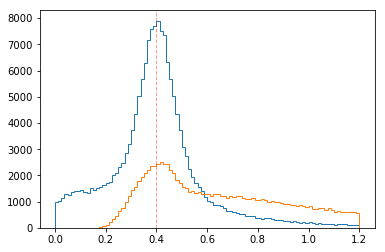

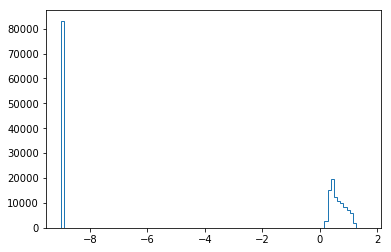

1.1999866962432861


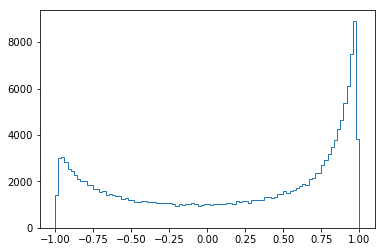

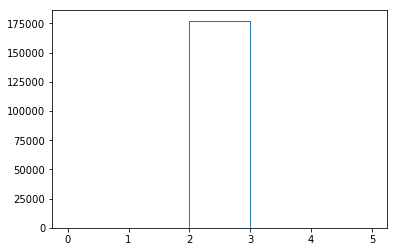

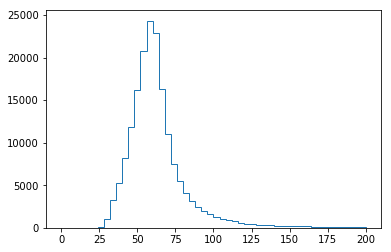

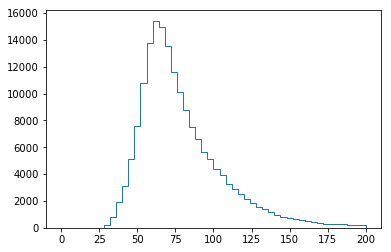

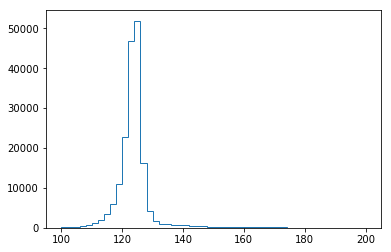

In [70]:
selection = (pho['pt'] > 0.)\
            & (pho['nRecoPho'] == 2)\
            #& (pho['pt'] < 100.)\
            # only for pi0 sel:
            #& (pho['bdt'] > -0.92)\
            #& (pho['sieie'] < 0.013)\
            #& (pho['chiso'] < 0.3)
mae2e = pho['ma'][selection]#[selection]
eta = pho['eta'][selection]
pt = pho['pt'][selection]
pu = pho['pu'][selection]

ma3b3 = pho['ma3b3'][selection]
mafc = pho['mafc'][selection]
phoidx = pho['id'][selection]

nbins = 140#56#28#14056#48
nbins = 120
nbins = 48*2
plt.hist(mae2e, histtype='step', range=(0., 1.2), bins=nbins)
plt.hist(ma3b3, histtype='step', range=(0., 1.2), bins=nbins)
plt.axvline(x=mass, color='r', linestyle='dashed', linewidth=1, alpha=0.4)
plt.show()

plt.hist(ma3b3, histtype='step', bins=nbins, range=(-9., 1.6))
plt.show()
print(np.max(ma3b3))

plt.hist(pho['bdt'][selection], histtype='step', range=(-1., 1.), bins=nbins)
plt.show()

plt.hist(pho['nRecoPho'][selection], histtype='step', range=(0., 5.), bins=5)
plt.show()

plt.hist(pt, histtype='step', range=(0., 200.), bins=50)
plt.show()

plt.hist(pho['energy'][selection], histtype='step', range=(0., 200.), bins=50)
plt.show()

plt.hist(pho['mgg'][selection], histtype='step', range=(100., 200.), bins=50)
plt.show()

60937 75341 31147 9835


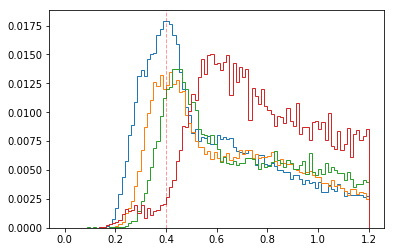

In [92]:
algo = 'e2e'
algo = 'phoNN'
algo = '3b3'
if algo == 'e2e':
    ma = mae2e
    algoText = 'End-to-end'
elif algo == 'phoNN':
    ma = mafc
    algoText = 'Photon NN'
elif algo == '3b3':
    ma = ma3b3
    algoText = '3x3 clustering'
else:
    raise Exception('invalid algo')
sg = 7.5
ptcut_lo, ptcut_hi = 62.5-sg, 62.5+sg
ptcut_ultra = 100.
#print(len(pt[pt<ptcut_lo]), len(pt[(pt>ptcut_lo)&(pt<ptcut_hi)]), len(pt[pt>ptcut_hi]))
print(len(pt[pt<ptcut_lo]), len(pt[(pt>ptcut_lo)&(pt<ptcut_hi)]), len(pt[(pt>ptcut_hi)&(pt<ptcut_ultra)]), len(pt[pt>ptcut_ultra]))
#plt.hist(ma, histtype='step', range=(0., 1.2), bins=nbins)
plt.hist(ma[pt<ptcut_lo], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[pt<ptcut_lo])/len(ma[pt<ptcut_lo]))
plt.hist(ma[(pt>ptcut_lo)&(pt<ptcut_hi)], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[(pt>ptcut_lo)&(pt<ptcut_hi)])/len(ma[(pt>ptcut_lo)&(pt<ptcut_hi)]))
plt.hist(ma[(pt>ptcut_hi)&(pt<ptcut_ultra)], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[(pt>ptcut_hi)&(pt<ptcut_ultra)])/len(ma[(pt>ptcut_hi)&(pt<ptcut_ultra)]))
#plt.hist(ma[pt>ptcut_hi], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[pt>ptcut_hi])/len(ma[pt>ptcut_hi]))
plt.hist(ma[pt>ptcut_ultra], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[pt>ptcut_ultra])/len(ma[pt>ptcut_ultra]))
#plt.hist(ma[pt>100.], histtype='step', range=(0., 1.2), bins=nbins, weights=np.ones_like(ma[pt>100.])/len(ma[pt>100.]))
plt.axvline(x=mass, color='r', linestyle='dashed', linewidth=1, alpha=0.4)
#plt.axvline(x=0.55, color='r', linestyle='dashed', linewidth=1, alpha=0.4)
plt.show()

In [93]:
import CMS_lumi, tdrstyle

ROOT.gStyle.SetPadTickX(1)
ROOT.gStyle.SetPadTickY(1)
#change the CMS_lumi variables (see CMS_lumi.py)
CMS_lumi.lumi_7TeV = "4.8 fb^{-1}"
CMS_lumi.lumi_8TeV = "18.3 fb^{-1}"
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "Simulation"
#CMS_lumi.lumi_sqrtS = "41.9 fb^{-1} (13 TeV)" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
#CMS_lumi.lumi_sqrtS = "13 TeV" # used with iPeriod = 0, e.g. for simulation-only plots (default is an empty string)
if mass >=1.:
    CMS_lumi.lumi_sqrtS = "m(a) = %.f GeV"%mass
elif mass == 0.:
    CMS_lumi.lumi_sqrtS = "photon"
else:
    #CMS_lumi.lumi_sqrtS = "m(a) = %.f MeV"%(mass*1.e3)
    CMS_lumi.lumi_sqrtS = "m(a) = %.1f GeV"%mass
    
#plot_dir = 'Plots/massreg/draft5'
plot_dir = 'Plots/massreg/vSPP'
print_pdf = True

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

79.0
m(a) = 0.4 GeV
test


Warning in <TCanvas::Constructor>: Deleting canvas with same name: chmA1vA2400MeV
Warning in <TROOT::Append>: Replacing existing TH1: hmA1vA2400MeV (Potential memory leak).
Info in <TCanvas::Print>: pdf file Plots/massreg/vSPP/h4g-hmA1vA2400MeV-3b3-bin25.pdf has been created


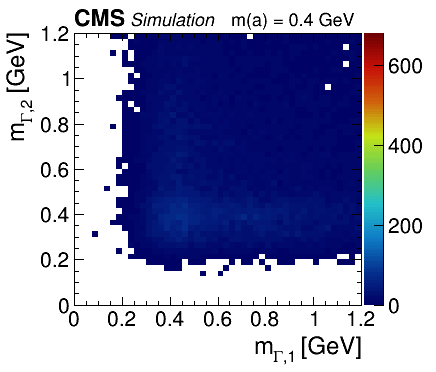

In [94]:
make_2dpdf = False

CMS_lumi.cmsTextOffset = 0.
CMS_lumi.lumiTextSize = 0.6
CMS_lumi.cmsTextSize = 0.75

iPos = 0
#if( iPos==0 ): CMS_lumi.relPosX = 0.16
if( iPos==0 ): CMS_lumi.relPosX = 0.195
iPeriod = 0

#wd, ht = int(480*1), int(400*1)
wd, ht = int(440*1), int(400*1)

#'''
k = 'hmA1vA2%dMeV'%int(mass*1e3)
c[k] = ROOT.TCanvas("c%s"%k,"c%s"%k,wd,ht)
#h[k] = ROOT.TH2F(k, k, 50, 20., 100., 48, 0., 1.2)
#h[k] = ROOT.TH2F(k, k, 35, 30., 100., 48, 0., 1.2)
h[k] = ROOT.TH2F(k, k, 48, 0., 1.2, 48, 0., 1.2)

m1s, m2s = ma[phoidx==0], ma[phoidx==1]
for m1,m2 in zip(m1s, m2s):
    h[k].Fill(m1, m2)
#'''

c[k].cd()
if make_2dpdf: h[k] = make_pdf(h[k])
h[k], c[k] = set_hist(h[k], c[k], "m_{#Gamma,1} [GeV]", "m_{#Gamma,2} [GeV]", "m_{#Gamma} vs. p_{T,a}")
ROOT.gPad.SetTopMargin(0.09)
ROOT.gPad.SetBottomMargin(0.18)
ROOT.gPad.SetLeftMargin(0.17)
ROOT.gPad.SetRightMargin(0.17) # no title
ROOT.gStyle.SetPalette(55)#53
h[k].SetTitle('')

h[k].GetYaxis().SetTitleSize(0.06)

#h[k].GetXaxis().SetTitleOffset(0.9)
h[k].GetXaxis().SetTitleSize(0.07)
h[k].GetZaxis().SetTitleFont(42)
h[k].GetZaxis().SetLabelFont(42)
h[k].GetYaxis().SetTitleFont(42)
h[k].GetYaxis().SetLabelFont(42)
h[k].GetXaxis().SetTitleFont(42)
h[k].GetXaxis().SetLabelFont(42)
#h[k].GetXaxis().SetNdivisions(505)

h[k].GetZaxis().SetTitleOffset(1.3)
h[k].GetZaxis().SetTitleSize(0.07)
h[k].GetZaxis().SetLabelSize(0.06)

h[k].GetYaxis().SetTitleOffset(1.1)
h[k].GetYaxis().SetTitleSize(0.07)
h[k].GetYaxis().SetLabelSize(0.06)

h[k].GetXaxis().SetTitleOffset(1.1)
h[k].GetXaxis().SetTitleSize(0.07)
h[k].GetXaxis().SetLabelSize(0.06)

h[k].GetXaxis().SetLabelOffset(0.01)
h[k].GetYaxis().SetLabelOffset(0.01)
h[k].GetZaxis().SetLabelOffset(0.01)

h[k].GetZaxis().SetMaxDigits(4)
h[k].GetZaxis().SetNdivisions(505)
h[k].SetContour(100)
h[k].SetMinimum(0.)
if make_2dpdf:
    pass
    #ROOT.gPad.SetLeftMargin(0.15)
    #ROOT.gPad.SetRightMargin(0.2)
    #h[k].GetZaxis().SetTitle("p(m_{#Gamma}|p_{T,a})")
    #h[k].GetZaxis().SetTitleOffset(1.35)
#else:
#    h[k].SetMaximum(60.)
print(h[k].GetMaximum())
#h[k].SetMaximum(1250)
#h[k].SetMaximum(2500)
h[k].SetMaximum(680)
h[k].Draw("COL Z")
CMS_lumi.CMS_lumi(c[k], iPeriod, iPos)
c[k].Draw()
#if make_2dpdf:
#    palette = h[k].GetListOfFunctions().FindObject("palette")
#    palette.SetX1NDC(0.795)
#    palette.SetX2NDC(0.845)
#    palette.SetY2NDC(0.92)
    #palette.SetX1NDC(0.815)
    #palette.SetX2NDC(0.865)
    #palette.SetY2NDC(0.92)
#palette[k] = h[k].GetListOfFunctions().FindObject("palette")
#palette[k].SetX1NDC(0.84)
#palette[k].SetX2NDC(0.89)
#palette[k].SetY1NDC(0.13)
#palette[k].SetY2NDC(0.9)
#c[k].Update()
#if print_png: c[k].Print('%s/%sMeV.png'%(plot_dir, k))
#if print_pdf: c[k].Print('%s/h4g-%s-%s.pdf'%(plot_dir, k, algo))
if print_pdf: c[k].Print('%s/h4g-%s-%s-bin25.pdf'%(plot_dir, k, algo))